# Neural Networks and CIFAR10 Classification

In the previous assignment you've taken a closer look to the binary classification scenario as well as the common steps that are shared between almost all deep learning projects, the so called "solver", using a simple logistic regression setup.

In this exercise, we will first take a closer look on the model side. In particular, you will implement self-contained building blocks that allow us to build complex models with ease. Afterwards, we will tackle the full pipeline once again, using new knowledge from our lectures to solve a more tricky task, i.e., general/non-binary classification. In particular, we will be using the CIFAR10 dataset that you developed in exercise 3, though we have to make some changes on the optimization and loss side, in comparison to your toy example in exercise 4. 

The notebook is quite long but there are not too many implementation tasks. More often we implemented certain aspects for you to showcase some nice features, but you should also look at our implementations to see the specific details. For a first pass however, you can choose to ditch those and focus on the blue boxes. 

Let's get started!

<img src="./images/2-layer-nn.png">

## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [25]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_09) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_05'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_05'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

In [26]:
# As usual, a bit of setup
import matplotlib.pyplot as plt
import numpy as np
import os

from exercise_code.data import (
    DataLoader,
    ImageFolderDataset,
    RescaleTransform,
    NormalizeTransform,
    FlattenTransform,
    ComposeTransform,
)
from exercise_code.networks import (
    ClassificationNet,
    CrossEntropyFromLogits
)
from exercise_code.tests.layer_tests import *
from exercise_code.tests.sgdm_tests import *

from exercise_code.solver import Solver
from exercise_code.networks.optimizer import (
    SGD,
    SGDMomentum,
    Adam
)
from exercise_code.networks.compute_network_size import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Neural Network Models

In `Exercise 4` you have already defined and implemented your first model. In order to understand the required building parts, it is important that you re-visit this structure as we intent to develop our model definition from there.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please re-read your implementation (in particular the necessary functions and variables) of our classifier class in Exercise 4 in <code>../exercise_04/exercise_code/networks/classifier.py</code>. </p>
</div>

In particular, we defined three important components:
- `__init__` and `initialize_weights`: that setup our classifier class, in particular we set up the weight matrix values here which we used for our logistic regression network
- `forward`: that takes an input, **caches that input** and uses that input
- `backward`: that computes gradient updates for our trained weight matrix


## 1.1 Modularization

The model you have implemented in `Exercise 4` was quite simple in nature, but if you would have to define multiple linear layer setups etc. it would get tricky quite quickly. Luckily, the lecture already provides us with a pleasant surprise that enables us to modularize the whole concepts of neural networks: the chain rule!

<img src="./images/chainrule.png">

Same as the displayed image above, this fact is huge! It is the cornerstone of modern deep neural network building. Since, if we want to chain multiple linear layers (together with some auxiliary layers such as non-linearities) together, we have to compute their respective derivatives in order to update their weight matrices. However, thanks to the chain rule, we can create small building blocks that
- in the `forward` pass do all required computations as well as save all values that are required to compute gradients and
- in the `backward` function they will use the incoming gradients from later building blocks, to compute their respective gradients using their cached values.

And therefore, we can just simply chain an arbitrary amount of such blocks, so called `layers`, together to create any structure we so desire (and finally which our hardware supports). Here is a more detailed code overview what we have to implement for those two passes:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output

  cache = (x, w, z, out) # Values we need to compute gradients

  return out, cache
```

and

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache

  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w

  return dx, dw
```

To check the correctness of your implementations below, we will again use numeric gradient checking

$$ \frac {df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

to compute values for layer outputs for your backward passees.

## 1.2 Layer Example: Non-Linearities

One of the simplest layers are non-linearities. They don't require any initial setup and we can easily write down their forward and backward passes.

### Sigmoid

Sigmoid is one of the oldest used non-linearities. You already implemented it in the last exercise together with other layers. For reference, here is the mathematical formula:
$$Sigmoid(x) = \frac{1}{1 + exp(-x)}$$
and its activation graph

<img src=https://pytorch.org/docs/stable/_images/Sigmoid.png alt="Figure4" width="400"/>

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Open the file <code>exercise_code/networks/layer.py</code>. Implement the <code>forward</code> and the <code>backward</code> method in the <code>Sigmoid</code> class, and test your implementation by running the following cell.
    </p>
</div>

In [27]:
# Test your sigmoid implementation
print(SigmoidTestWrapper()())

SigmoidForwardTest passed.
SigmoidBackwardTest passed.
Congratulations! You have passed all the unit tests!!! Tests passed: 2/2
Score: 100/100
You secured a score of: 100


### Relu

Rectified Linear Units are the currently most used non-linearities in deep learning. They are not without flaws though they solve some issues introduced by non-linearities such as sigmoid above. Here is the formula
$$ReLU(x) = max(0, x)$$
and its clean graph
<img src=https://pytorch.org/docs/stable/_images/ReLU.png alt="Figure2" width="400"/>
<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Open the file <code>exercise_code/networks/layer.py</code>. Implement the <code>forward</code> and the <code>backward</code> method in the <code>Relu</code> class, and test your implementation by running the following cell.
    </p>
</div>

In [28]:
# Test your ReLu implementation
print(ReluTestWrapper()())

ReluForwardTest passed.
ReluBackwardTest passed.
Congratulations! You have passed all the unit tests!!! Tests passed: 2/2
Score: 100/100
You secured a score of: 100


## 1.3 Affine Layers

Our two layers above have no trainable weights and would make a poor network. As discussed in the lecture, Neural Networks use so called affine or linear layers that each has a learned weight matrix which we optimize in our training process.

We deviate from our narrative here a little bit and focus our implementation efforts on the forward and backward passes of linear layers. Later on, you will encounter them in Pytorch again. There, they fully modularize those which makes network creation much simpler for the consumer/non-implementer ;).

An affine layer computes a function of

$$\mathbf{z} = \mathbf{W} \mathbf{x} + \mathbf{b}$$

where $W$ is our learned weight matrix.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Open the file <code>exercise_code/networks/layer.py</code>. Implement the <code>affine_forward</code> and the <code>affine_backward</code> function and test your implementation by running the following cell.
    </p>
</div>

In [29]:
# Test your affine layer implementations
print(AffineTestWrapper()())

AffineForwardTest passed.
AffineBackwardTestDx passed.
AffineBackwardTestDw passed.
AffineBackwardTestDb passed.
Congratulations! You have passed all the unit tests!!! Tests passed: 4/4
Score: 100/100
You secured a score of: 100


## 1.4 N-layer Classification Network

Now that you have all necessary building blocks, you can build up your first neural network model. However, as stated above, we have omitted some details in the initialization of said network. We advise you to take a look at our network implementation to get a feel of how everything is computed.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation in <code>exercise_code/networks/classification_net.py</code>.
 </p>
</div>

We can then simply call the network as shown below in the case of a rather small two layers network using two linear layers of size $128$ as well as Relu non-linearities in-between.

In [30]:
# Define a dummy input
test_input = np.random.randn(1, 10)   # (batch_size, input_size)

# Define a test model
test_model = ClassificationNet(input_size=10, 
                               hidden_size=128,
                               activation=Relu(), 
                               num_layer=2, 
                               num_classes=3)

# Compute output
model_output = test_model.forward(test_input)
print('Model output shape:', model_output.shape)

Model output shape: (1, 3)


# 2. CIFAR10 Dataset

Great! Now that we modularized our layers and are able to build any networks based of linear layers as well as non-linearities, let's start checking out our data again!

Let us first do some setup to be back at our state of after completing exercise 3.

In [31]:
# Define output path similar to exercise 3
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(i2dl_exercises_path, "datasets", "cifar10")

# Dictionary so that we can convert label indices to actual label names
classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
]

# Simply call dataset class
dataset = ImageFolderDataset(
        root=cifar_root
    )

Now we can set up a dataset iterate over it and visualize images as well as labels easily just like that.

Sample 0
image shape: (32, 32, 3)
label: bird
Sample 1
image shape: (32, 32, 3)
label: cat
Sample 2
image shape: (32, 32, 3)
label: truck

Sample images


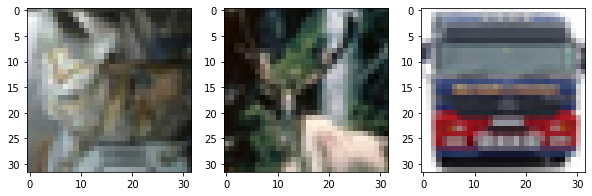

In [32]:
num_images = 3

for i in range(num_images):
    item = dataset[i]
    image = item['image']
    label = item['label']
    
    # Print shape and label
    print('Sample {}\nimage shape: {}\nlabel: {}'.format(
        i, image.shape, classes[label]))
    
    # Visualize image
    plt.subplot(1, num_images, 1 + i)
    plt.imshow(image.astype('uint8'))

print('\nSample images')
plt.show()

Cool. We are basically done at this point bar transforms. In exercise 3 we made sure to normalize our images so we should do it here as well.

However, we also have to consider our network to accommodate the dataset output to our network input. In our case, we require a one dimensional input vector. The simplest way to realize this is to flatten the vector which we do so by an additional transform and compose all of them together such as described below.

In [33]:
# Use the Cifar10 mean and standard deviation computed in Exercise 3.
cifar_mean = np.array([0.49191375, 0.48235852, 0.44673872])
cifar_std  = np.array([0.24706447, 0.24346213, 0.26147554])

# Define all the transforms we will apply on the images when 
# retrieving them.
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)

# Add the new flatten transform
flatten_transform = FlattenTransform()

# And string them together
compose_transform = ComposeTransform([
    rescale_transform, 
    normalize_transform,
    flatten_transform
])

Now, our outputs are sufficiently resized and we can apply our transforms on initializing our dataset. 

Before testing any deep learning pipeline, you should overfit on a small sample first which will be our goal for this notebook: we only take $1\%$ (or 500 images) of our training data to overfit on later and set up our dataset and dataloader accordingly.

### The crux of loading from disk
If you are using google colab or store your files on a local HDD, iterating over dataset takes quite some time. This is problematic, since we want to iterate over the dataset in future exercises. The issue is that we have acess single files every time we access a dataset element which are then loaded into the memory.

Luckily, the CIFAR10 dataset is small enough to fit into the memory for most systems since it's total file size is around 1.2GB. 

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>Loading the whole dataset into memory will not work if you are using a machine with 4GB of RAM or less (depending on your other programs such as memory hungry web browsers). Consider closing some open programs or simply use the local on-demand ImageFolderDataset.</p>
    <p>In addition we want to warn you that everytime you execute a cell like "dataset2 = MemoryImageFolderDataset..." you are loading a 1.2GB matrix into your memory. If you do this often enough this notebook will crash on every machine. Therefore, we make sure to always use a single variable "dataset" which will be overwritten by future cells to avoid straining your memory too much.</p>
</div>

We created a second CIFAR10 dataset for you where we load all images into the memory instantly instead of loading them on demand at access time, which speeds up the loading speed immensly, especially on google colab. You can check out the code under `exercise_coder/data/image_folder_dataset`.

In [34]:
# Don't execute this cell on low RAM machines
from exercise_code.data import MemoryImageFolderDataset
### colab only ###
# import urllib.request
### colab only ###


### Choose your preferred dataset here
If you want to switch to the MemoryImageFolderDataset for the remaining notebook, please change the following cell

In [35]:
DATASET = ImageFolderDataset
#DATASET = MemoryImageFolderDataset

In [36]:
# Create a dataset and dataloader
batch_size = 8

dataset = DATASET(
    mode='train',
    root=cifar_root,
    transform=compose_transform,
    split={'train': 0.01, 'val': 0.2, 'test': 0.79}
)
    
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

print('Dataset size:', len(dataset))
print('Dataloader size:', len(dataloader))

Dataset size: 500
Dataloader size: 62


Let's do a quick check if the image input is sufficient. An image should be a single array of size $3*32*32$ and we should have `batch_size` of them per batch.

In [37]:
num_batches = 3

for i, item in enumerate(dataloader):
    image_batch = item['image']
    print('Batch {} image shape: {}'.format(i, image_batch.shape))
    
    if i >= num_batches-1:
        break

Batch 0 image shape: (8, 3072)
Batch 1 image shape: (8, 3072)
Batch 2 image shape: (8, 3072)


OK, now we have to define a network that can work with those inputs. For simplicity, we are starting with a small two-layer neural network with two hidden layers of size 128.

In [38]:
# First get dataset entry for our network input size
sample_image = dataset[0]['image']

input_size = sample_image.shape[0]
print('Input size:', input_size)

# Define our model
model = ClassificationNet(input_size=input_size, 
                          hidden_size=128,
                          activation=Relu(), 
                          num_layer=2, 
                          num_classes=10)

Input size: 3072


Similarly to above we can use our dataloader to iterate over the dataloader and now apply our network on each batch:

In [39]:
# Iterate over the network using our dataloader
for i, item in enumerate(dataloader):
    images = item['image']
    
    output = model.forward(images)
    
    print('Batch {} output shape {}'.format(i, output.shape))
    if i >= num_batches-1:
        break

Batch 0 output shape (8, 10)
Batch 1 output shape (8, 10)
Batch 2 output shape (8, 10)


Great, let's move on.

# 3. Cross-Entropy/Softmax Loss from Logits

There is still something left to fix before we can start though. In exercise 4 you tackled a binary problem. However, CIFAR10 consists of 10 classes. Therefore, we can't just simply use a binary objective function. Luckily, we can generalize our Binary Cross-Entropy Loss from exercise 4.

<div class="alert alert-warning">
    <h3>Note: Softmax Loss</h3>
    <p>This usually confuses people: in literature the general <b>Cross-Entropy</b> Loss is often simply called <b>Softmax Loss</b>, due to the Softmax activation function.
         </p>
</div>

## Definition

$$ CE(\hat{y}, y) = \frac{1}{N} \sum_{i=1}^N \sum_{k=1}^{C} \Big[ -y_{ik} \log(\hat{y}_{ik}) \Big] $$

where:
- $ N $ is again the number of samples
- $ C $ is the number of classes
- $ \hat{y}_{ik} $ is the probability that the model assigns for the $k$'th class when the $i$'th sample is the input. 
- $y_{ik} = 1 $ iff the true label of the $i$th sample is $k$ and 0 otherwise. This is called a [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

<div class="alert alert-success">
    <h3>Task: Check Formula</h3>
    <p>Check for yourself that when the number of classes $ C $ is 2, then binary cross-entropy is actually equivalent to cross-entropy.</p>
</div>

## From Logits

If we are not applying an activation function on the last layer of our network, its outputs for each sample will not be a valid probability distribution over the classes. We call these raw outputs of the network '[logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045)' and we will apply a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation in order to obtain a valid "probability distribution".

## Implementation
We implemented the general formulation for you. There are some details you should check out:

### Numerical Stability
First check out the computation of the softmax itself. Recall that 
$$softmax(x)=\sigma(x)=\frac{e^{x_i}}{\sum_{i=1}^ne^{x_i}}$$
for a vector $x=(x_i)_{(1\leq i\leq n)}\in\mathbb{R}^n$.
However, the sum in the divisor is problematic when using floating point numbers as the resulting fraction can be too small to be accurately represented and yield numerical instabilities.

One solution would be to instead consider
$$\sigma(x-\max_{1\leq i\leq n}x_i)$$

which ensures that our divisor is small enough to avoid numerical instabilities.

<div class="alert alert-success">
    <h3>Task: Proof</h3>
    <p>Think about why this solves the numerical stability problem and prove that $\sigma(x)=\sigma(x+c)$ for any constant vector $c\in\mathbb{R}^n$.</p>
</div>

With that proof, we can simply switch out the softmax computation with the new vector above and avoid numerical instabilities.

### Matrix Notation

In order to implement the whole procedure efficiently, we use numpy to evaluate the whole batch computation. This is non-trivial, though we implement it for you in this notebook such that you can save time. We highly urge you, however, to think about the implementation for yourself first and then check out our implementation of the cross-entropy loss, including its backward pass.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Check the implemenation of the Softmax Loss under <code>exercise_code/networks/loss/CrossEntropyFromLogits</code> including the backward pass and think through it yourself to understand the matrix operations. Finally, compare it to the binary cross-entropy implementation in the same file or your previous implementation from last week.</p>
</div>

### Sanity Check

Let's quickly check if our loss formulation works as intended. Let's compute the loss of a random vector from our network defined above.

In [16]:
# Set up loss
loss_func = CrossEntropyFromLogits()

# Sample input from a single image
sample_image = dataset[0]['image']
sample_label = dataset[0]['label']
single_image_batch = np.expand_dims(sample_image, 0)
single_label_batch = np.expand_dims(sample_label, 0)

# Feed forward using our network
model_output = model.forward(single_image_batch)

# Loss computation
computed_loss, _ = loss_func(model_output, single_label_batch)
print('Loss of single image sample:', computed_loss)

Loss of single image sample: 2.3025235137032287


<div class="alert alert-success">
    <h3>Task: Reason</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
</div>

# 4. Optimization

We are nearly there yet. The final piece of our pipeline is to define our optimization method. In this week's lecture, you've seen a variety of possibilities at which we should take a look now.

## 4.1 Gradient Descent vs Stochastic Gradient Descent

For demonstration sake, let us compute the memory required to do a full gradient descent update on our small CIFAR10 dataset consisting of 500 images.

In [17]:
# Define our model again
model = ClassificationNet(input_size=input_size, 
                          hidden_size=128,
                          activation=Relu(), 
                          num_layer=2, 
                          num_classes=10)

In order to do so, we have to calculate the forward caches as well as the computed gradients for each update step. Before we go into details of actual update methods, let us compute those manually.

<div class="alert alert-warning">
    <h3>Optional: Compute Network Size</h3>
    <p>Our network itself is quite small, as a quick check you can compute the size of the network defined above yourself by summing up all network weights. Compare them against the values computed below.</p>
</div>

A more challenging task is to calculate the memory required to compute one network forward pass. Lets just quickly do this for a small batch with our small model. In order to populate the forward caches, we have to make a forward pass using a batch.

In [18]:
# Set up loss
loss_func = CrossEntropyFromLogits()

# Get a random batch of our dataloader with batch_size 8
sample_batch = iter(dataloader).__next__()
sample_images = sample_batch['image']
sample_labels = sample_batch['label']

# Compute model output
model_output = model.forward(sample_images)

Since we are always saving our inputs for each of our layers (in order to be able to backpropagate using them later) we amass quite a lot of values for our forward pass using 8 images. We've implemented a way to calculate those in bytes and you should check out this implementation as well as the network background.

Using said function, we can calculate the network size as shown below:

In [19]:
num_bytes = compute_network_pass_size(model)

print('\nTotal number of bytes used by network for batch:', GetHumanReadable(num_bytes))

Adding layer caches for forward pass:
affine1 3147120
sigmoid1 896
affine2 18880

Adding layer gradients for backward pass:
W1 24
b1 24
W2 24
b2 24

Total number of bytes used by network for batch: 3.02MB


OK, 3MB is not too shabby but also not a crazy high number. Your memory should easily handle it. However, we still have to add the memory required for the backward pass. In order to do so, we have to populate the gradients. Above you can see that those are only 24 bytes in size and that is because they are empty. Let's change that by doing one backward pass manually.

In [20]:
# 1. Compute loss
_ = loss_func.forward(model_output, sample_labels)
# 2. Compute loss gradients
dout = loss_func.backward(model_output, sample_labels)
# 3. Backpropagate gradients through model
_ = model.backward(dout)

# Now calculate bytes again
num_bytes = compute_network_pass_size(model)

print('\nTotal number of bytes used by network for batch:', GetHumanReadable(num_bytes))

Adding layer caches for forward pass:
affine1 3147120
sigmoid1 896
affine2 18880

Adding layer gradients for backward pass:
W1 3145856
b1 1136
W2 10368
b2 192

Total number of bytes used by network for batch: 6.03MB


<div class="alert alert-warning">
    <h3>Optional: Check Code</h3>
    <p>Check our implementation to compute the size of a network forward pass in bytes in <code>exercise_code/networks/compute_network_size.py</code>, which simply sums up the caches values as well as gradients. You should also think about how and why those caches/gradients are populated using the steps above.</p>
</div>

Nice! That is the amount of memory required to do a full training forward and backward pass using our small batch. 

However, if we wanted to compute the memory required to do a full gradient update for the CIFAR10 dataset using our small network, you'd need...

In [40]:
# A current batch consists of 8 images. The whole dataset would require 50000/8 times the amount of memory
num_bytes = num_bytes * 50000 / 8

print('Total number of bytes used by network for the whole dataset', GetHumanReadable(num_bytes))

Total number of bytes used by network for the whole dataset 224.69TB


And that is the case why we usually have to use stochastic approaches to train neural networks :). For smaller tasks however, you can not only use regular gradient descent but also second order optimization approaches. For more info about those we refer to the lecture.

## 4.2 SGD

We start off with plain Stochastic Gradient Descent (SGD) which we implemented for you.

Now that we have an optimizer, we can execute the full pipeline using our pre-written solver which is similar to the one you wrote in the previous exercise.

<div class="alert alert-warning">
    <h3>Note: Good Practice</h3>
    <p>Always, always, always when starting a new project or defining a new network: <b>overfit on a small set first and then generalize</b>. The 500 images we are using here are already too many sample for most cases. Start with a single sample, then 10 and finally a few hundred. Don't cheap out on this step! More often, your network will fail to generalize properly and you have to first know if it has enough capacity to overfit and that the full training pipeline is working!</p>
    <p>In order to run these experiments, you don't necessarily need a validation set. Just a few training samples are enough to make those checks!</p>
</div>

In [22]:
# Redefine model and loss function
model = ClassificationNet(input_size=input_size, 
                          hidden_size=128,
                          activation=Relu(), 
                          num_layer=2, 
                          num_classes=10)

loss_func = CrossEntropyFromLogits()

In [23]:
learning_rate = 1e-2

# We use our training dataloader for validation as well as testing
solver = Solver(model, dataloader, dataloader, 
                learning_rate=learning_rate, loss_func=loss_func, optimizer=SGD)

# This might take a while depending on your hardware. When in doubt: use google colab
solver.train(epochs=20)

(Epoch 1 / 20) train loss: 2.302592; val loss: 2.302594
(Epoch 2 / 20) train loss: 2.302138; val loss: 2.299428
(Epoch 3 / 20) train loss: 2.294407; val loss: 2.278096
(Epoch 4 / 20) train loss: 2.250822; val loss: 2.200809
(Epoch 5 / 20) train loss: 2.168045; val loss: 2.092365
(Epoch 6 / 20) train loss: 2.076503; val loss: 1.999571
(Epoch 7 / 20) train loss: 1.984513; val loss: 1.886599
(Epoch 8 / 20) train loss: 1.877739; val loss: 1.779179
(Epoch 9 / 20) train loss: 1.781808; val loss: 1.674429
(Epoch 10 / 20) train loss: 1.695713; val loss: 1.596891
(Epoch 11 / 20) train loss: 1.616551; val loss: 1.503856
(Epoch 12 / 20) train loss: 1.533559; val loss: 1.415558
(Epoch 13 / 20) train loss: 1.432651; val loss: 1.329038
(Epoch 14 / 20) train loss: 1.348683; val loss: 1.229133
(Epoch 15 / 20) train loss: 1.274442; val loss: 1.120638
(Epoch 16 / 20) train loss: 1.168718; val loss: 1.051031
(Epoch 17 / 20) train loss: 1.076549; val loss: 0.955450
(Epoch 18 / 20) train loss: 0.977439; va

## 4.3 SGD + Momentum

As you can see, the loss is going down smoothly which indicates that we are easily overfitting. Great. However, plain SGD is rarely used in practice (as it is usually too slow) which is why we will focus on implementing SGD+Momentum now, which is a straightforward extension to SGD.

Recall that its update rule is defined by:

$$ v^{k+1} = \beta v^{k} - \alpha \nabla_{\theta} L (\theta^{k}),$$
$$ \theta^{k+1} = \theta^{k} + v^{k+1}.$$

<div class="alert alert-info">
    <h3>Task: Check Code and Implement </h3>
    <p>Familiarize yourself with the SGD implementation in <code>exercise_code/networks/optimizer.py</code> as well as our general optimization class structure.</p>
    <p> Then, implement the <code>SGDMomentum._update</code> function which is very similar to the update rule of SGD above.
</div>

In [41]:
#Test your SGD momentum implementations
print(SGDMTestWrapper()())

SGDM_Weight_Test passed.
SGDM_Velocity_Test passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
Score: 100/100
You secured a score of :100


## 4.4 Adam

There are a variety of updates that people have suggested for SGD. For a more detailed overview of optimizers and their development, we refer to [this educational blog post](https://ruder.io/optimizing-gradient-descent/).

Besides SGD+Momentum (which is still used quite often and you should never discard it), the currently most used optimizer however is Adam. In comparison to SGD, it uses a first and second order momentum.

<div class="alert alert-warning">
    <h3>Task: Check Code</h3>
    <p>We have implemented Adam's update rule for you and you can check out the implementation in <code>exercise_code/networks/optimizer.py</code>.</p>
</div>

## 4.5 Optimizer Comparison

Finally, let's compare our different optimization methods against each other on our small testing dataloader with shared parameters. That can take some time.

Starting SGD
(Epoch 1 / 20) train loss: 2.302626; val loss: 2.302627
(Epoch 2 / 20) train loss: 2.302594; val loss: 2.302400
(Epoch 3 / 20) train loss: 2.302358; val loss: 2.302170
(Epoch 4 / 20) train loss: 2.302126; val loss: 2.301938
(Epoch 5 / 20) train loss: 2.301875; val loss: 2.301622
(Epoch 6 / 20) train loss: 2.301631; val loss: 2.301354
(Epoch 7 / 20) train loss: 2.301273; val loss: 2.301024
(Epoch 8 / 20) train loss: 2.300891; val loss: 2.300603
(Epoch 9 / 20) train loss: 2.300399; val loss: 2.300123
(Epoch 10 / 20) train loss: 2.299929; val loss: 2.299543
(Epoch 11 / 20) train loss: 2.299215; val loss: 2.298773
(Epoch 12 / 20) train loss: 2.298383; val loss: 2.297774
(Epoch 13 / 20) train loss: 2.297490; val loss: 2.296558
(Epoch 14 / 20) train loss: 2.296130; val loss: 2.295097
(Epoch 15 / 20) train loss: 2.294380; val loss: 2.293075
(Epoch 16 / 20) train loss: 2.292369; val loss: 2.290680
(Epoch 17 / 20) train loss: 2.289851; val loss: 2.287671
(Epoch 18 / 20) train loss:

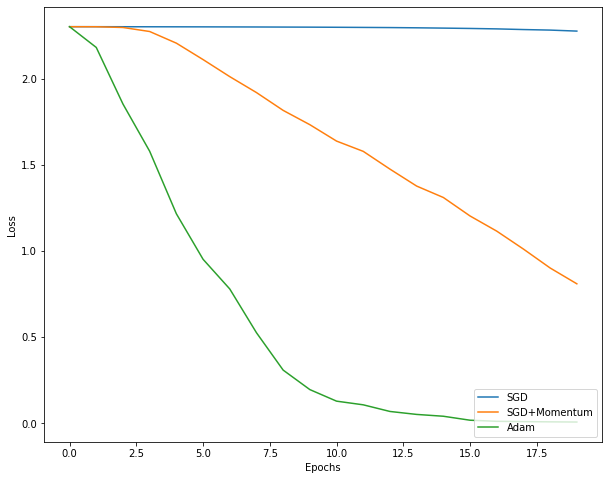

In [27]:
learning_rate = 1e-3
num_epochs = 20
loss_func = CrossEntropyFromLogits()

# Compute loss histories for all optimizers
loss_histories = {}

for name, optimizer in zip(['SGD', 'SGD+Momentum', 'Adam'], [SGD, SGDMomentum, Adam]):
    print('Starting {}'.format(name))
    # Reset model
    model = ClassificationNet(input_size=input_size, 
                              hidden_size=128,
                              activation=Relu(), 
                              num_layer=2, 
                              num_classes=10)
    # Set up solver
    solver = Solver(model, dataloader, dataloader, 
                    learning_rate=learning_rate, loss_func=loss_func,
                    optimizer=optimizer)
    solver.train(epochs=num_epochs)
    # Save train history to plot later
    loss_histories[name] = solver.train_loss_history
    print()

# Plot them in a shared plot
for name in loss_histories:
    plt.plot(loss_histories[name], '-', label=name)
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Phew... that was a lot of work, but with this plot exercise 5 is done :).

# 6. Outlook

Should you always use Adam, as this single experiment using a fixed set of parameters suggests? How would you perform on unseen data using this network? Which network is the best?

All of these questions have a shared condition: **hyperparameters**! Basically everything we touched in this notebook is a hyperparameter for a deep learning task:
- the network architecture,
- data transformations,
- optimizer,
- and much more.

But how do you choose good hyperparameters? They will not magically appear and since we are computer scientists we are allergic to excessive manual testing. Therefore, we will show ways to come up with them in an automated manner in our next exercise, so stay tuned :).

# 7. Submission Instructions
Hooooooray, you trained your model! The model will be saved as a pickle file to `models/NN.p`.


In [42]:
from exercise_code.tests import save_pickle
from exercise_code.networks.layer import *
from exercise_code.networks.optimizer import SGDMomentum

save_pickle(
    data_dict={
        "SGD_Momentum_update": SGDMomentum._update,
        "AffineForward": affine_forward,
        "AffineBackward": affine_backward,
        "Sigmoid": Sigmoid,
        "Relu": Relu,
    },
    file_name="NN.p"
)

Now, that you have completed the necessary parts in the notebook, you can go on and submit your files.

1. Go on [our submission page](https://i2dl.dvl.in.tum.de/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum-online and check your mails there. You will get an id which we need in the next step.
2. Log into [our submission page](https://i2dl.dvl.in.tum.de/) with your account details and upload the zip file.
3. Your submission will be evaluated by our system and you will get feedback about the performance of it. You will get an email with your score as well as a message if you have surpassed the threshold.
4. Within the working period, you can submit as many solutions as you want to get the best possible score.

Simply run the following cell to create a zipped file for your implementations.

In [43]:
from exercise_code.submit import submit_exercise


submit_exercise('../output/exercise05')

relevant folders: ['models', 'exercise_code']
notebooks files: ['1_NeuralNetworks.ipynb']
Adding folder models
Adding folder exercise_code
Adding notebook 1_NeuralNetworks.ipynb
Zipping successful! Zip is stored under: /home/clemens/TUM/4_Semester/I2DL/i2dl_exercises/output/exercise05.zip


# Submission Goals

- Goals: Implement all implementation tasks.
- Test cases: 
    1. Does `forward()` of `Sigmoid` layer return the correct value during forward pass?
    2. Does `backward()` of `Sigmoid` layer return the correct value during backward pass?
    3. Does `forward()` of `Relu` layer return the correct value during forward pass?
    4. Does `backward()` of `Relu` layer return the correct value during backward pass?
    5. Does `affine_forward()` return the correct value of `out`?
    6. Does `affine_backward()` return the correct value of `dx`?
    7. Does `affine_backward()` return the correct value of `dw`?
    8. Does `affine_backward()` return the correct value of `db`?
    9. Does `update()` of SGDMomentum return the correct weight values after update?
    10. Does `update()` of SGDMomentum return the correct velocity values after update?

- Reachable points [0, 100]: 0 if not implemented, 100 if all tests passed, 10 per passed test
- Threshold to clear exercise: 100
- Submission start: __May 31, 2022, 13.00__
- Submission deadline : __June 13, 2022, 23.59__ 
- You can make multiple submission until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform)
We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform) for this exercise so that we can do better next time! :)